# Labeling

Next step is clustering since we are building a classifier but we don't have labels yet. The goal is to cluster our dataset and then evaluate some representants of their clusters and assign the whole cluster a label.

## Outliers

As first attempts of clustering showed, outliers in our dataset affect our basic clustering methods. So in the beginning of labeling process we try to filter those outliers out. Using search over contamination parameter where score is computed as mean of standard deviations of clusters' sizes using Agglomerative and KMeans algorithms (as they are quite general), we want to find the most suitable settings of outliers detection.

We compute filtered dataset size to standard deviation ratios and find the maximum value since that's probably the best trade-off between dataset reduction (we don't want to filter half of our dataset out) and outliers' affection of clustering methods (since they don't make clusters where there are just few members in).

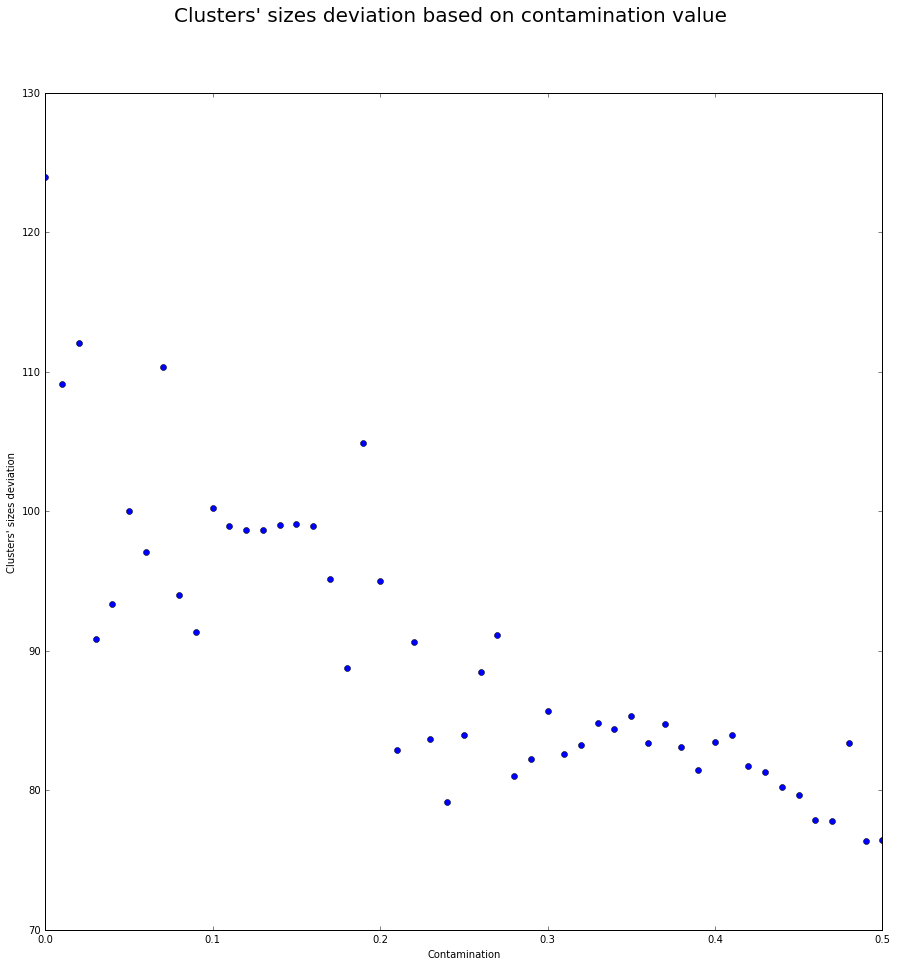

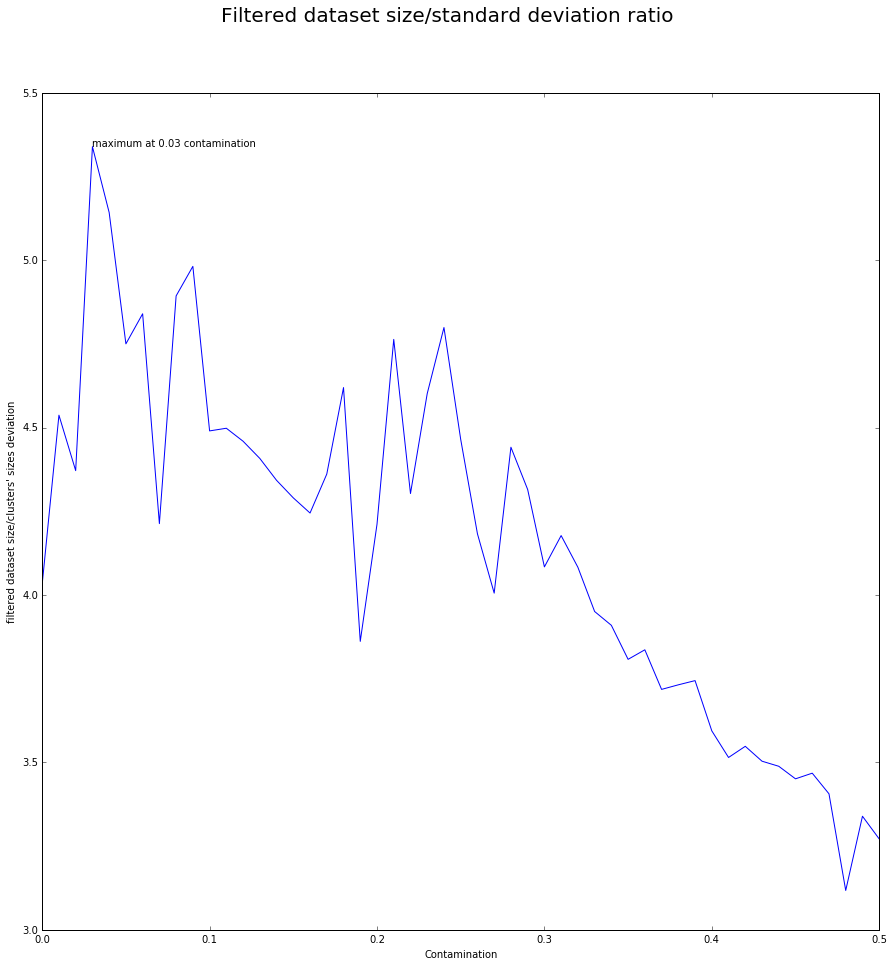

In [1]:
# Outliers removal

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.manifold import MDS
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import AgglomerativeClustering, KMeans

# disable warnings
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('../data/sample-manually-scaled.csv')
X = scale(data.values[:,1:])

# project dataset into 2D space
mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X)

conts = []
stds = []
ratios = []

for contamination in np.arange(0, 0.51, 0.01):
    envelope = EllipticEnvelope(contamination=contamination)
    # detect ouliers
    outliers = envelope.fit(X_mds).predict(X_mds)
    
    # remove outliers from dataset
    filtered = data.select(lambda idx: outliers[idx] > 0)
    X = scale(filtered.values[:,1:])
    
    # perform agglomerative clustering on filtered dataset
    clstr = AgglomerativeClustering(n_clusters=5)
    labels = clstr.fit_predict(X)
    _, counts = np.unique(labels, return_counts=True)
    
    # compute standard deviation of clusters' sizes
    agglo_std = np.std(counts)
    
    # perform kmeans clustering
    clstr = KMeans(n_clusters=5)
    labels = clstr.fit_predict(X)
    _, counts = np.unique(labels, return_counts=True)
    
    # compute standard deviation of clusters' sizes
    kmeans_std = np.std(counts)
    
    # compute mean of standard deviations
    std = np.mean([agglo_std, kmeans_std])
    
    # add values to plot data
    conts.append(contamination)
    stds.append(std)
    ratios.append(sum(counts) / std)

fig = plt.figure(figsize=(15, 15), facecolor='white')
fig.suptitle('Clusters\' sizes deviation based on contamination value', size=20)
plt.plot(conts, stds, 'bo')
plt.xlabel('Contamination')
plt.ylabel('Clusters\' sizes deviation')

fig = plt.figure(figsize=(15, 15), facecolor='white')
ax = fig.add_subplot(111)
fig.suptitle('Filtered dataset size/standard deviation ratio', size=20)
plt.plot(conts, ratios)
plt.xlabel('Contamination')
plt.ylabel('filtered dataset size/clusters\' sizes deviation')

max_ratio = max(ratios)
idx = ratios.index(max_ratio)
ax.annotate('maximum at {0} contamination'.format(conts[idx]), xy=(conts[idx], ratios[idx]))

plt.show()